#### Name:  Xuan Zhang

## Problem 

Use LSTM to analyze S&P 500 returns over the period 2004-2006.

The data file "stock-treasury-2004_2006.csv", to be found in the "Data" folder, contains the following:  
+ TREAS_3M: the yield of the 3-month treasury note in percent (i.e 2.1 means 2.1%)
+ Adjusted close price of ten major stocks: GM, F, UTX, CAT, MRK, PFE, IBM, MSFT, C, XOM
+ SP: The S&P 500 equity index level at the close of the trading day  

**Do the following:**  

Use the pandas read_csv function to read the Date and SP columns in a data frame called "sp_df".  
Rename the "SP" column into "ClosePx" in the same read_csv call.  
Compute the close-to-close index returns as:  $r_t = P_{t+1}/P_t - 1$ and add them as a new column "DailyRet".  
It is recommended to express all daily returns in basis points (10,000 bps = 100% = 1)

We want to train an RNN that looks back $M$ days and forecasts forward $N$ days.  
Therefore the RNN will use return sequences of size $M$, and targets of size $N$.  

Reformat the return data suitable for RNN processing as follows.  
From the "DailyRet" column of "sp_df", create a data input matrix $X$ containing rows as below:    
$$r_0, r_1, r_2, \ldots, r_{M-1}$$  
$$r_1, r_2, r_3, \ldots, r_{M}$$  
$$r_2, r_3, r_4, \ldots, r_{M+1}$$  
$$\ldots$$
From the "DailyRet" column of "sp_df", create also a target matrix $y$ containing rows as below:
$$ r_{M}, r_{M+1}, \ldots, r_{M+N-1}$$
$$ r_{M+1}, r_{M+2}, \ldots, r_{M+N}$$
$$ r_{M+2}, r_{M+3}, \ldots, r_{M+N+1}$$
$$\ldots$$

Set $M=16$ and $N=4$.  
Build an RNN with two LSTM cells and train it on the first 607 sequences.  
This means that the training set contains returns with the latest date of 2016-05-31.    
Use the remaining returns for out-of-sample testing.  
This is a regression task, so train the network using mean_squared_error loss.  
When connecting the two LSTMs, make sure you set the parameter return_sequences=True on the first LSTM, 
so that the second can see the sequences.

Compute the out-of-sample actual and predicted 2-day, 3-day, ..., N-day return, by summing 1-day forward returns up to this horizon.  
N-day return is the return from today's close to the close of the N-th day forward from today.  
Calculate and report the RMSE and the correlation between actual and predicted 1-day, 2-day, ..., N-day returns.  
Plot the actual and predicted returns in the out-of-sample part.  
What do you conclude regarding the quality of the forecasts?


## Solution 

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
np.random.seed(42)

from keras.datasets import mnist
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Conv2D, MaxPooling2D, Flatten, SimpleRNN, LSTM
from keras.callbacks import EarlyStopping

from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler


Using TensorFlow backend.


## import data

In [2]:
plt.style.use('ggplot')
M=16
N=4

sp_df=pd.read_csv("stock-treasury-2004_2006.csv",
                  usecols=[0,12],parse_dates=['Date'],header=0,names=['Date','ClosePx'])
        
sp_df.head()

,Date,ClosePx
0,2004-01-02,1108.48
1,2004-01-05,1122.22
2,2004-01-06,1123.67
3,2004-01-07,1126.33
4,2004-01-08,1131.92


In [3]:
sp_df = sp_df.assign(DailyRet=10000 * (sp_df.ClosePx.shift(periods=-1)/ sp_df.ClosePx - 1))
sp_df.head()

,Date,ClosePx,DailyRet
0,2004-01-02,1108.48,123.953522
1,2004-01-05,1122.22,12.920818
2,2004-01-06,1123.67,23.672431
3,2004-01-07,1126.33,49.630215
4,2004-01-08,1131.92,-88.875539


In [4]:
sp_df.tail()

,Date,ClosePx,DailyRet
668,2006-08-28,1301.78,19.204474
669,2006-08-29,1304.28,8.357101
670,2006-08-30,1305.37,-11.874028
671,2006-08-31,1303.82,55.145649
672,2006-09-01,1311.01,NaN


## rescale train data

In [6]:
traindata=np.array(sp_df.DailyRet)[0:607].reshape(-1,1)
scaler = MinMaxScaler(feature_range=(-1, 1))
traindata = scaler.fit_transform(traindata)
traindata=pd.Series(np.squeeze(traindata))
X_trainoriginal=traindata

In [336]:
X_train = np.array([X_trainoriginal[0:M]])
for i in range(1,(len(X_trainoriginal)-M+1-N)):
    xadd = np.array([X_trainoriginal[i:i+M]])
    X_train=np.vstack((X_train,xadd))
X_train = X_train.reshape((-1, M, 1))
X_train.shape

(588, 16, 1)

In [337]:
y_train = np.array([X_trainoriginal[M:M+N]])
for i in range(M+1,(len(X_trainoriginal)-N+1)):
    xadd = np.array([X_trainoriginal[i:i+N]])
    y_train=np.vstack((y_train,xadd))
y_train.shape

(588, 4)

In [338]:
y_train

array([[-0.75215881,  0.22510419, -0.17511201,  0.15480958],
       [ 0.22510419, -0.17511201,  0.15480958, -0.00140475],
       [-0.17511201,  0.15480958, -0.00140475, -0.47691249],
       ...,
       [ 0.04616983,  0.56039631,  0.26347798, -0.86986174],
       [ 0.56039631,  0.26347798, -0.86986174,  0.38919919],
       [ 0.26347798, -0.86986174,  0.38919919,  0.60917362]])

In [339]:
X_train = X_train.reshape((-1, M, 1))
y_train = y_train.reshape((-1, N))

## construct model

In [340]:
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2]),return_sequences=True,activation='linear'))
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(N))

In [341]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 16, 50)            10400     
_________________________________________________________________
lstm_14 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dense_7 (Dense)              (None, 4)                 204       
Total params: 30,804
Trainable params: 30,804
Non-trainable params: 0
_________________________________________________________________


In [342]:
model.compile(loss='mean_squared_error', optimizer='nadam', metrics=['accuracy'])

In [343]:
history = model.fit(X_train, y_train, epochs=100, batch_size=72, validation_split=0.1, verbose=1)

Train on 529 samples, validate on 59 samples
Epoch 1/100
529/529 [==============================] - 4s 7ms/step - loss: 0.1240 - acc: 0.2476 - val_loss: 0.1091 - val_acc: 0.2373
Epoch 2/100
529/529 [==============================] - 0s 358us/step - loss: 0.1236 - acc: 0.2571 - val_loss: 0.1079 - val_acc: 0.2373
Epoch 3/100
529/529 [==============================] - 0s 364us/step - loss: 0.1236 - acc: 0.2552 - val_loss: 0.1084 - val_acc: 0.2542
Epoch 4/100
529/529 [==============================] - 0s 371us/step - loss: 0.1234 - acc: 0.2439 - val_loss: 0.1080 - val_acc: 0.2542
Epoch 5/100
529/529 [==============================] - 0s 366us/step - loss: 0.1235 - acc: 0.2231 - val_loss: 0.1080 - val_acc: 0.2542
Epoch 6/100
529/529 [==============================] - 0s 368us/step - loss: 0.1234 - acc: 0.2363 - val_loss: 0.1079 - val_acc: 0.2542
Epoch 7/100
529/529 [==============================] - 0s 370us/step - loss: 0.1233 - acc: 0.2382 - val_loss: 0.1078 - val_acc: 0.2542
Epoch 8/100


Epoch 61/100
529/529 [==============================] - 0s 848us/step - loss: 0.1167 - acc: 0.3006 - val_loss: 0.1080 - val_acc: 0.2373
Epoch 62/100
529/529 [==============================] - 0s 670us/step - loss: 0.1151 - acc: 0.3214 - val_loss: 0.1085 - val_acc: 0.2881
Epoch 63/100
529/529 [==============================] - 0s 784us/step - loss: 0.1156 - acc: 0.3176 - val_loss: 0.1080 - val_acc: 0.2712
Epoch 64/100
529/529 [==============================] - 0s 795us/step - loss: 0.1142 - acc: 0.3119 - val_loss: 0.1115 - val_acc: 0.3051
Epoch 65/100
529/529 [==============================] - 0s 865us/step - loss: 0.1137 - acc: 0.3327 - val_loss: 0.1117 - val_acc: 0.2712
Epoch 66/100
529/529 [==============================] - 0s 873us/step - loss: 0.1119 - acc: 0.3308 - val_loss: 0.1188 - val_acc: 0.2203
Epoch 67/100
529/529 [==============================] - 0s 625us/step - loss: 0.1118 - acc: 0.3308 - val_loss: 0.1124 - val_acc: 0.2881
Epoch 68/100
529/529 [==========================

## rescale test data

In [344]:
testdata=np.array(sp_df.DailyRet)[607:len(sp_df)-1].reshape(-1,1)
scaler = MinMaxScaler(feature_range=(-1, 1))
testdata = scaler.fit_transform(testdata)
testdata=pd.Series(np.squeeze(testdata))

In [345]:
X_testoriginal=testdata
X_testoriginal.reset_index(inplace=True,drop=True)
X_testoriginal.head()

0    0.003536
1   -1.000000
2   -0.153473
3   -0.405191
4   -0.023656
dtype: float64

In [346]:
X_test = np.array([X_testoriginal[0:M]])
for i in range(1,(len(X_testoriginal)-M-N)):
    xadd = np.array([X_testoriginal[i:i+M]])
    X_test=np.vstack((X_test,xadd))
X_test = X_test.reshape((-1, M, 1))
X_test.shape

(45, 16, 1)

In [347]:
y_test = np.array([X_testoriginal[M:M+N]])
for i in range(M+1,(len(X_testoriginal)-N)):
    xadd = np.array([X_testoriginal[i:i+N]])
    y_test=np.vstack((y_test,xadd))
y_test.shape

(45, 4)

## test score and loss

In [348]:
test_val_score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss score: {0:.4f}'.format(test_val_score[0]))
print('Test accuracy:   {0:.4f}'.format(test_val_score[1]))

Test loss score: 0.2315
Test accuracy:   0.2222


## make predictions

In [349]:
y_pred = model.predict(X_test)
y_pred.shape

(45, 4)

## transform scaled test data to original state

In [350]:
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test)

## Calculate 1 day, 2 day, 3 day, 4 day returns

In [351]:
y_predcumsum=np.cumsum(y_pred,axis=1) 
y_testcumsum=np.cumsum(y_test,axis=1) 

## RMSE and Correlation

In [352]:
from sklearn import metrics
rmselist=[]
corrlist=[]
for i in range(N):
    rmse=np.sqrt(metrics.mean_squared_error(y_predcumsum[:,i], y_testcumsum[:,i]))
    rmselist.append(rmse)
    corr=np.corrcoef(y_predcumsum[:,i], y_testcumsum[:,i])[0,1]
    corrlist.append(corr)
    print("The %d day rmse is is %f, corr is %f" % (i+1,rmse,corr))


The 1 day rmse is is 99.155141, corr is -0.021979
The 2 day rmse is is 145.391972, corr is 0.067523
The 3 day rmse is is 167.667202, corr is -0.111708
The 4 day rmse is is 180.300575, corr is -0.143005


## plot of predict and actual data

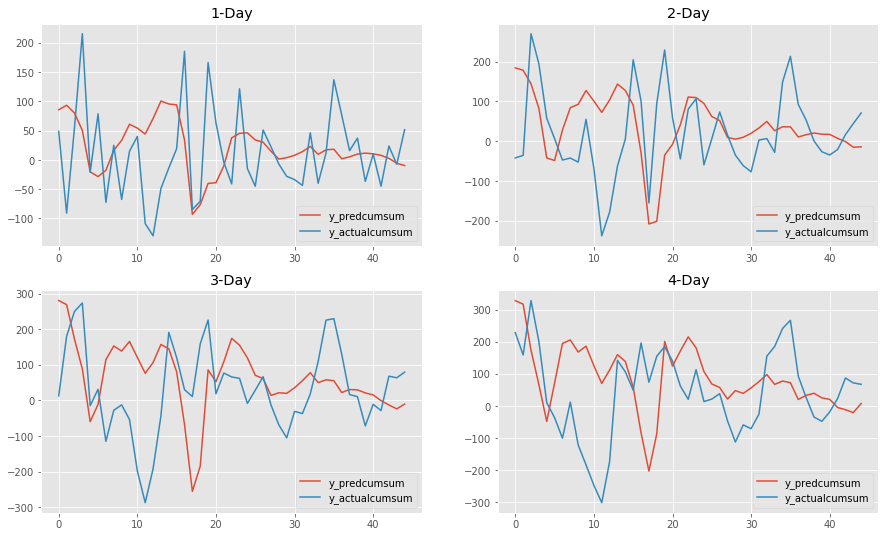

In [329]:
plt.figure(1,figsize=(15,9)) 
for i in range(N):
    plt.subplot(2,2,i+1) #要生成两行两列，这是第一个图plt.subplot('行','列','编号')
    plt.plot(y_predcumsum[:,i])
    plt.plot(y_testcumsum[:,i])
    plt.legend(["y_predcumsum","y_actualcumsum"],loc =4)
    titlename=''.join([str(i+1),"-Day"])
    plt.title(titlename)
plt.show()

## What do you conclude regarding the quality of the forecasts?

### According to correlation, the prediction and the actual data don't have strong linear correlation. According to rmse, the prediciton errors are a little big. According to plot above, the predction have the similar trend with actual data.